# Introdução ao Aprendizado Profundo (Deep Q-Network)

#### Prof. Armando Alves Neto - Introdução ao Aprendizado por Reforço - PPGEE/UFMG

<img src="lunar_lander.gif" width="400">

Objetivo: utilizar o algoritmo de DQN para treinar o pouso de uma sonda lunar na posição entre as duas bandeiras.

## Características da sonda lunar:

### Espaço de observações

Espaço de estados com 8 dimensões:
- posições $x$ e $y$ 
- velocidades lineares em $x$ e $y$ 
- ângulo 
- velocidade angular 
- dois contatos (boleanos) representando o contato de cada perna com o chão.

### Espaço de ações

Existem quatro ações possíveis:
- fazer nada
- acionar propulsor de orientação à esquerda
- acionar propulsor principal
- acionar propulsor de orientação à direita

### Função de reforço

Para cada passo, o reforço:
- é aumentado/diminuído quanto mais próximo/mais o módulo de pouso estiver da plataforma de pouso
- é aumentado/diminuído quanto mais lento/mais rápido o módulo de pouso estiver se movendo
- diminui quanto mais o lander é inclinado (ângulo não horizontal)
- é aumentado em 10 pontos para cada perna que está em contato com o solo
- é reduzido em 0,03 pontos a cada quadro que um motor lateral está disparando
- é diminuído em 0,3 pontos a cada quadro que o motor principal está disparando.

O episódio recebe uma recompensa adicional de -100 ou +100 pontos por bater ou pousar com segurança, respectivamente. Um episódio é considerado uma solução se obtiver pelo menos 200 pontos.

### Estados terminais

O episódio termina se:
- a sonda atingir o solo
- a sonda sair do campo de visão (coordenada x maior que 1)
- a sonda parar de se mover

Importando bibliotecas.

In [1]:
import gym
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10,5)
from IPython.display import clear_output
from collections import deque, namedtuple
import seaborn as sns
sns.set()

Cria uma classe (```RunningAverage()```) apenas para calcular a média móvel do sinal de reforço.

In [2]:
class RunningAverage(object):
    def __init__(self, N):
        self.buffer = deque(maxlen=N)

    def push(self, val):  
        self.buffer.append(val)

    def get(self):
        return np.mean(self.buffer)

Define arquitetura da Rede Neural Artificial (Perceptron) com ```state_size```entradas, ```action_size``` saídas e duas camadas escondidas de tamanho ```hidden```.

In [3]:
class QNetwork(nn.Module):
    ##########################################
    def __init__(self, state_size, action_size, hidden=64):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden)
        self.fc2 = nn.Linear(hidden, hidden)
        self.fc3 = nn.Linear(hidden, action_size)

    ##########################################
    # Build a network that maps state -> action values.
    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

Gerenciando o replay buffer. O buffer tem tamanho fixo e armazena tuplas de experiências com o ambiente.

In [4]:
class ReplayBuffer:
    ##########################################
    def __init__(self, parameters, action_size, buffer_size=int(1e5)):
        self.action_size = action_size
        self.batch_size = parameters['batch_size']
        self.device = parameters['device']
        
        self.memory = deque(maxlen=buffer_size)  
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
    
    ##########################################
    # Add a new experience to memory.
    def add(self, S, A, R, Sl, done):
        e = self.experience(S, A, R, Sl, done)
        self.memory.append(e)
    
    ##########################################
    # Escolhe aleatoriamente um mini-lote das experiencias
    def sample(self):
        Dj = random.sample(self.memory, k=np.min([len(self.memory), self.batch_size]))
    
        states = torch.from_numpy(np.vstack([e.state for e in Dj if e is not None])).float().to(self.device)
        actions = torch.from_numpy(np.vstack([e.action for e in Dj if e is not None])).long().to(self.device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in Dj if e is not None])).float().to(self.device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in Dj if e is not None])).float().to(self.device)
        dones = torch.from_numpy(np.vstack([e.done for e in Dj if e is not None]).astype(np.uint8)).float().to(self.device)
  
        return (states, actions, rewards, next_states, dones)
    
    ##########################################
    # Return the current size of internal memory.
    def __len__(self):
        return len(self.memory)

Cria classe do algoritmo de DQN.

In [5]:
class DQN(object):
    def __init__(self, parameters):
        
        self.parameters = parameters

        # numero de episodios
        self.episode = 0
        self.max_iter = parameters['max_iter']
        
        # parametros de aprendizado
        self.gamma = parameters['gamma']
        self.eps = parameters['eps']
        self.alpha = parameters['alpha']
        self.device = parameters['device']
        
        # cria ambiente
        self.env = gym.make('LunarLander-v2')
        self.env.seed(0)
        
        # Q-Network
        self.qnetwork = QNetwork(state_size=self.env.observation_space.shape[0], action_size=self.env.action_space.n).to(self.device)
        
        # otimizador
        self.optimizer = optim.Adam(self.qnetwork.parameters(), lr=self.alpha)
        
        # Buffer de armazenamento de experiencias
        self.D = ReplayBuffer(parameters, action_size=self.env.action_space.n)
        
    ##########################################
    # politica epsilon-greedy 
    def act(self, state):

        state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
        self.qnetwork.eval()
        with torch.no_grad():
            action_values = self.qnetwork(state)
        self.qnetwork.train()

        # Epsilon-greedy action selection
        if np.random.random() > self.eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return np.random.choice(np.arange(self.env.action_space.n))

Executa um episódio do DQN.

In [6]:
class DQN(DQN):
    def runEpisode(self, print_every=20):
    
        # novo episodio
        self.episode += 1
        
        rewards = []
        
        # determina o estado inicial
        S = self.env.reset()

        for _ in range(parameters['max_iter']):
            
            # Escolhe uma ação (epsilon-greedy)
            A = self.act(S)
            Sl, R, done, _ = self.env.step(A)
            rewards.append(R)
            
            # Armazena a experiencia (S,A,R,Sl) no buffer D
            self.D.add(S, A, R, Sl, done)

            # Seleciona um mini-lote Dj de D e apŕende
            Ss, As, Rs, Sls, dones = self.D.sample()

            # Calcula o alvo da função valor-ação
            y = Rs + self.gamma*self.qnetwork(Sls).detach().max(1)[0].unsqueeze(1) * (1 - dones)

            ### Calculate expected value from local network
            qhat = self.qnetwork(Ss).gather(1, As)

            # Função de perda (erro médio quadrático)
            loss = F.mse_loss(y, qhat)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            # renderiza eventualmente
            if self.episode % print_every == 0:
                self.env.render()

            # proximo estado
            S = Sl
            
            if done: break

        return np.sum(np.array(rewards))

Programa principal.

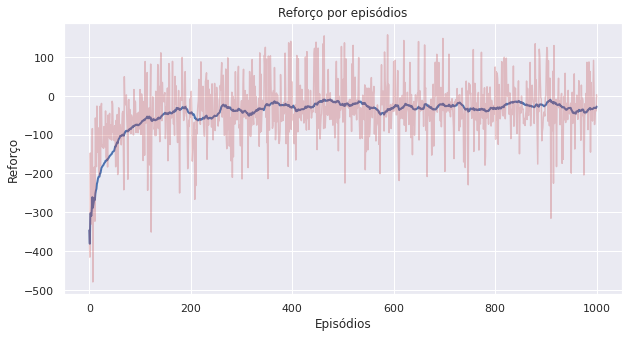

In [7]:
##########################################
# main
##########################################
if __name__ == '__main__':
    
    plt.ion()

    # cria objeto para calculo da média movel do reward
    avg_calc = RunningAverage(50)
    
    # parametros
    parameters = {'episodes'  : 1000,
                  'max_iter'  : 1000,
                  'gamma'     : 0.99,
                  'eps'       : 5.0e-1,
                  'alpha'     : 5.0e-4,
                  'batch_size': 64,     # minibatch size
                  'device'    : torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
                  }
    
    # historico dos reforços
    rewards = []
    avg_rewards = []
    
    dqn = DQN(parameters)
    
    while dqn.episode <= parameters['episodes']:
        
        # roda um episodio
        total_reward = dqn.runEpisode()

        # rewards
        rewards.append(total_reward)
        # reward medio
        avg_calc.push(total_reward)
        avg_rewards.append(avg_calc.get())

        plt.figure(1)
        clear_output(wait=True)
        plt.clf()
        plt.plot(avg_rewards, 'b', linewidth=2)
        plt.plot(rewards, 'r', alpha=0.3)
        plt.title('Reforço por episódios')
        plt.xlabel('Episódios')
        plt.ylabel('Reforço')

        plt.show()
        plt.pause(.1)

    plt.ioff()